Epoch 0 Training loss 0.6809244284146949 Validation Loss : 0.6000042036175728
Epoch 1 Training loss 0.5828064638602583 Validation Loss : 0.5249063685536385
Epoch 2 Training loss 0.5228658318519592 Validation Loss : 0.4721013426780701
Epoch 3 Training loss 0.4685075083110906 Validation Loss : 0.4290189653635025
Epoch 4 Training loss 0.4310002394869358 Validation Loss : 0.39139566719532015
Epoch 5 Training loss 0.39752000947541827 Validation Loss : 0.36153759360313414
Epoch 6 Training loss 0.3679884662733802 Validation Loss : 0.3300868310034275
Epoch 7 Training loss 0.3406543941060199 Validation Loss : 0.3083589941263199
Epoch 8 Training loss 0.32561209345165687 Validation Loss : 0.2894469924271107
Epoch 9 Training loss 0.3030805491571185 Validation Loss : 0.2743448905646801
Epoch 10 Training loss 0.2843358296005032 Validation Loss : 0.26067183166742325
Epoch 11 Training loss 0.27138570516924315 Validation Loss : 0.2515947364270687
Epoch 12 Training loss 0.2638995927534526 Validation Los

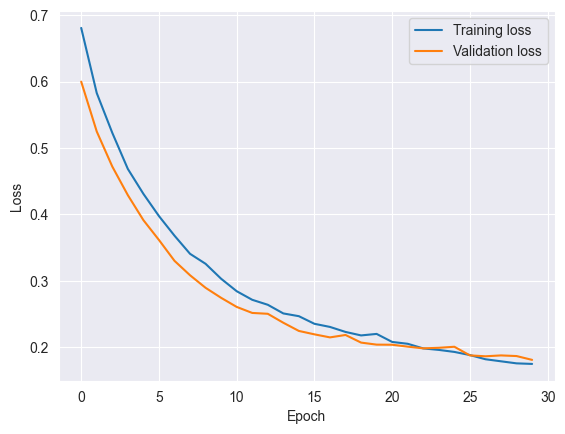

Finished Training


In [8]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt

batch_size = 16
torch.manual_seed(210401002)
# define a custom dataset class
class Dataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = torch.tensor(self.data.iloc[idx, :-1].values, dtype=torch.float32)
        y = torch.tensor(self.data.iloc[idx, -1], dtype=torch.float32)
        return x, y

train_dataset = Dataset("cure_the_princess_train.csv")
validation_dataset = Dataset("cure_the_princess_validation.csv")
test_dataset = Dataset("cure_the_princess_test.csv")



# create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle= False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

classes = ('Phoenix Feather','Unicorn Horn','Dragon''s Blood','Mermaid Tears','Fairy Dust','Goblin Toes','Witch''s Brew','Griffin Claw','Troll Hair','Kraken Ink','Minotaur Horn','Basilisk Scale','Chimera Fang','Cured')


class MLP(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size):
        super(MLP, self).__init__()
        self.hidden_layer1 = nn.Linear(input_size, hidden_size_1)
        self.hidden_layer2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.output_layer = nn.Linear(hidden_size_2, output_size)
        self.ReLu = nn.ReLU()
        self.ReLu2 = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):

        hidden_res1 = self.ReLu(self.hidden_layer1(x))
        hidden_res2 = self.ReLu2(self.hidden_layer2(hidden_res1))
        output = self.sigmoid(self.output_layer(hidden_res2))
        return output
learning_rate = 0.0001
num_epochs = 30
patience = 5

# dataiter = iter(train_loader)
# images, labels = next(dataiter)
# print(images.size(0), images.size(1))
# print(len(classes))


num_input_feats = len(classes) - 1
num_of_hidden_size_1, num_of_hidden_size_2 = 100, 50
num_of_output = 1

model = MLP(num_input_feats,num_of_hidden_size_1,num_of_hidden_size_2, num_of_output)

# Loss function ve optimizer
criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

list_train_loss, list_val_loss = [], []
best_val_loss = None
patience_counter = 0

# Train the model
for epoch in range(num_epochs):

    # training loop
    train_loss = 0.0
    train_count = 0.0
    for inputs, labels in train_loader:
        model.train()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()

        train_count += 1.0
        train_loss += loss.item()
     

    val_loss = 0.0
    #validation_count = 0.0
    with torch.no_grad():
        model.eval()
        for inputs, labels in validation_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            #validation_count += 1.0
            val_loss += loss.item()
            """_, predicted = torch.max(outputs, 1) # burada validation accuracy hesabı var.
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()"""

    

    # calculate metrics
    train_loss /= train_count
    val_loss /= len(validation_loader)
    #val_acc = 100 * val_correct / val_total

    print("Epoch", epoch, "Training loss", train_loss,"Validation Loss :",val_loss)

    list_train_loss.append(train_loss)
    list_val_loss.append(val_loss)

    val_score = val_loss
    if best_val_loss is None:
        best_val_loss = val_score # hafızada patience boyu tutmaya başla
        torch.save(model.state_dict(), "checkpoint.pt")
    elif best_val_loss < val_score: # patience counter
        patience_counter += 1
        print("Earlystopping Patience Counter:",patience_counter)
        if patience_counter == patience:
            break
    else:
        best_val_loss = val_score
        torch.save(model.state_dict(), "checkpoint.pt") # to keep the best model
        patience_counter = 0

sns.set_style("darkgrid")
plt.plot(list_train_loss, label="Training loss")
plt.plot(list_val_loss, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

print('Finished Training')

In [4]:
from torcheval.metrics.functional import multiclass_f1_score
from torcheval.metrics.functional import multiclass_accuracy
# TESTING 1
# Task 2
model = MLP(num_input_feats,num_of_hidden_size_1,num_of_hidden_size_2,num_of_output,)

checkpoint = torch.load("checkpoint.pt")
model.load_state_dict(checkpoint)

# switch to evaluation mode
model.eval()

test_loss = 0.0
test_count = 0.0
test_correct = 0.0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        test_count += 1.0
        test_loss += loss.item()

        # calculate accuracy
        predicted = outputs.round()
        test_correct += (predicted == labels.unsqueeze(1)).sum().item()

test_loss /= test_count
test_acc = 100 * test_correct / len(test_dataset)
print("Test Loss:", test_loss, "Test Accuracy:", test_acc)

Test Loss: 0.18183965692106557 Test Accuracy: 93.39378238341969


In [6]:
from sklearn.metrics import f1_score,accuracy_score,classification_report,recall_score,precision_score
#TESTING 2
test_loss = 0.0
test_count = 0.0
y_true, y_pred = [], []
with torch.no_grad():
    model.eval()
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        test_count += 1.0
        test_loss += loss.item()
        predicted = (outputs > 0.5).float()
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy().flatten())

# calculate evaluation metrics
accuracy = np.mean(np.array(y_true) == np.array(y_pred))
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")

print("Test loss: {:.4f}, Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1 score: {:.4f}".format(
    test_loss/test_count, accuracy, precision, recall, f1))

Test loss: 0.1818, Accuracy: 0.9339, Precision: 0.9358, Recall: 0.9339, F1 score: 0.9339


In [7]:
#TESTING 3

model = MLP(num_input_feats,num_of_hidden_size_1,num_of_hidden_size_2,num_of_output)
model.load_state_dict(torch.load('checkpoint.pt'))
model.eval()
predicts =[]
real_labels = list()
with torch.no_grad():
    for inputs,label in test_loader:
        outputs = model(inputs)
        _,predict = torch.max(outputs.data,1)
        predicts.extend(predict.tolist())
        real_labels.extend(label.tolist())


from sklearn.metrics import f1_score,accuracy_score,classification_report
print("Accuracy score of this model: {}".format(accuracy_score(real_labels,predicts)))
print(classification_report(real_labels,predicts))

Accuracy score of this model: 0.49740932642487046
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.66       384
         1.0       0.00      0.00      0.00       388

    accuracy                           0.50       772
   macro avg       0.25      0.50      0.33       772
weighted avg       0.25      0.50      0.33       772



c:\Users\hasan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hasan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hasan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,